# QClus Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append('..')

import qclus as qc
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [16]:
splicing_path = "../../data/fraction_unspliced.csv"
counts_path = "../../data/counts.h5"

In [17]:
fraction_unspliced = pd.read_csv(splicing_path, index_col=0)

In [18]:
fraction_unspliced.head()

,fraction_unspliced
AAACGCTCAGATACCT,0.259897
AAACCCAGTGAATGTA,0.774209
AAACGAACATTGACCA,0.526074
AAACCCAAGCAGCACA,0.832765
AAACGAATCCACAGGC,0.794653


In [21]:
adata = qc.run_qclus(counts_path, fraction_unspliced)                            # outlier filter setting

In [22]:
adata

AnnData object with n_obs × n_vars = 25096 × 36601
    obs: 'fraction_unspliced', 'n_genes_by_counts', 'total_counts', 'total_counts_nuclear', 'pct_counts_nuclear', 'score_nuclear', 'total_counts_MT', 'pct_counts_MT', 'score_MT', 'total_counts_MT_nucl', 'pct_counts_MT_nucl', 'score_MT_nucl', 'total_counts_CM_cyto', 'pct_counts_CM_cyto', 'score_CM_cyto', 'total_counts_CM_nucl', 'pct_counts_CM_nucl', 'score_CM_nucl', 'total_counts_VEC', 'pct_counts_VEC', 'score_VEC', 'total_counts_PER', 'pct_counts_PER', 'score_PER', 'total_counts_SMC', 'pct_counts_SMC', 'score_SMC', 'total_counts_AD', 'pct_counts_AD', 'score_AD', 'total_counts_SC', 'pct_counts_SC', 'score_SC', 'total_counts_N', 'pct_counts_N', 'score_N', 'total_counts_EEC', 'pct_counts_EEC', 'score_EEC', 'total_counts_FB', 'pct_counts_FB', 'score_FB', 'total_counts_L', 'pct_counts_L', 'score_L', 'total_counts_MESO', 'pct_counts_MESO', 'score_MESO', 'total_counts_MP', 'pct_counts_MP', 'score_MP', 'pct_counts_nonCM', 'kmeans', 'qclus'
   

In [23]:
adata.obs.qclus.value_counts()

qclus
passed               8245
outlier filter       5769
initial filter       4236
clustering filter    4231
scrublet filter      2615
Name: count, dtype: int64

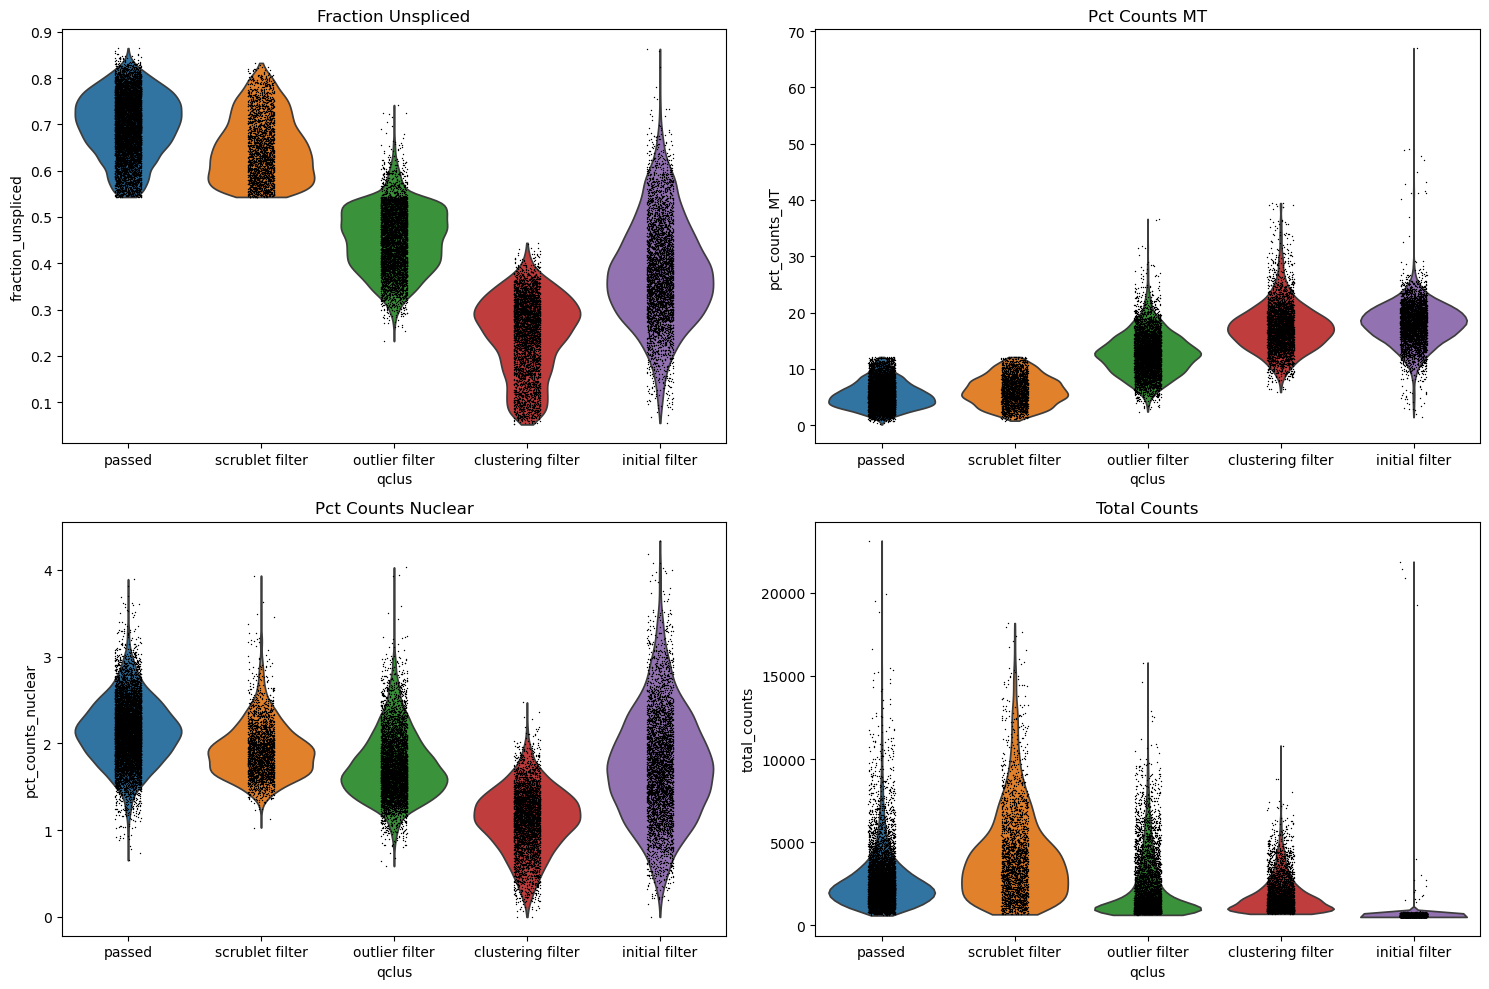

In [24]:
# Define the desired order of qclus categories
desired_order = ['passed', 'scrublet filter', 'outlier filter', 'clustering filter', 'initial filter']

# Get the unique values present in the qclus column
unique_qclus_values = adata.obs['qclus'].unique().tolist()

# Filter the desired order to only include categories that are present in the data
qclus_order = [category for category in desired_order if category in unique_qclus_values]

# Ensure the qclus column is a categorical type with the specified order
adata.obs['qclus'] = adata.obs['qclus'].astype('category')
adata.obs['qclus'] = adata.obs['qclus'].cat.reorder_categories(qclus_order, ordered=True)

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot each subplot
sc.pl.violin(adata, 'fraction_unspliced', groupby='qclus', order=qclus_order, ax=axs[0, 0], show=False)
axs[0, 0].set_title('Fraction Unspliced')

sc.pl.violin(adata, 'pct_counts_MT', groupby='qclus', order=qclus_order, ax=axs[0, 1], show=False)
axs[0, 1].set_title('Pct Counts MT')

sc.pl.violin(adata, 'pct_counts_nuclear', groupby='qclus', order=qclus_order, ax=axs[1, 0], show=False)
axs[1, 0].set_title('Pct Counts Nuclear')

sc.pl.violin(adata, 'total_counts', groupby='qclus', order=qclus_order, ax=axs[1, 1], show=False)
axs[1, 1].set_title('Total Counts')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [25]:
#filter out initial_filter annotated cells
adata = adata[adata.obs.qclus!="initial filter"]
adata.obsm["QClus_umap"] = adata.uns["QClus_umap"]

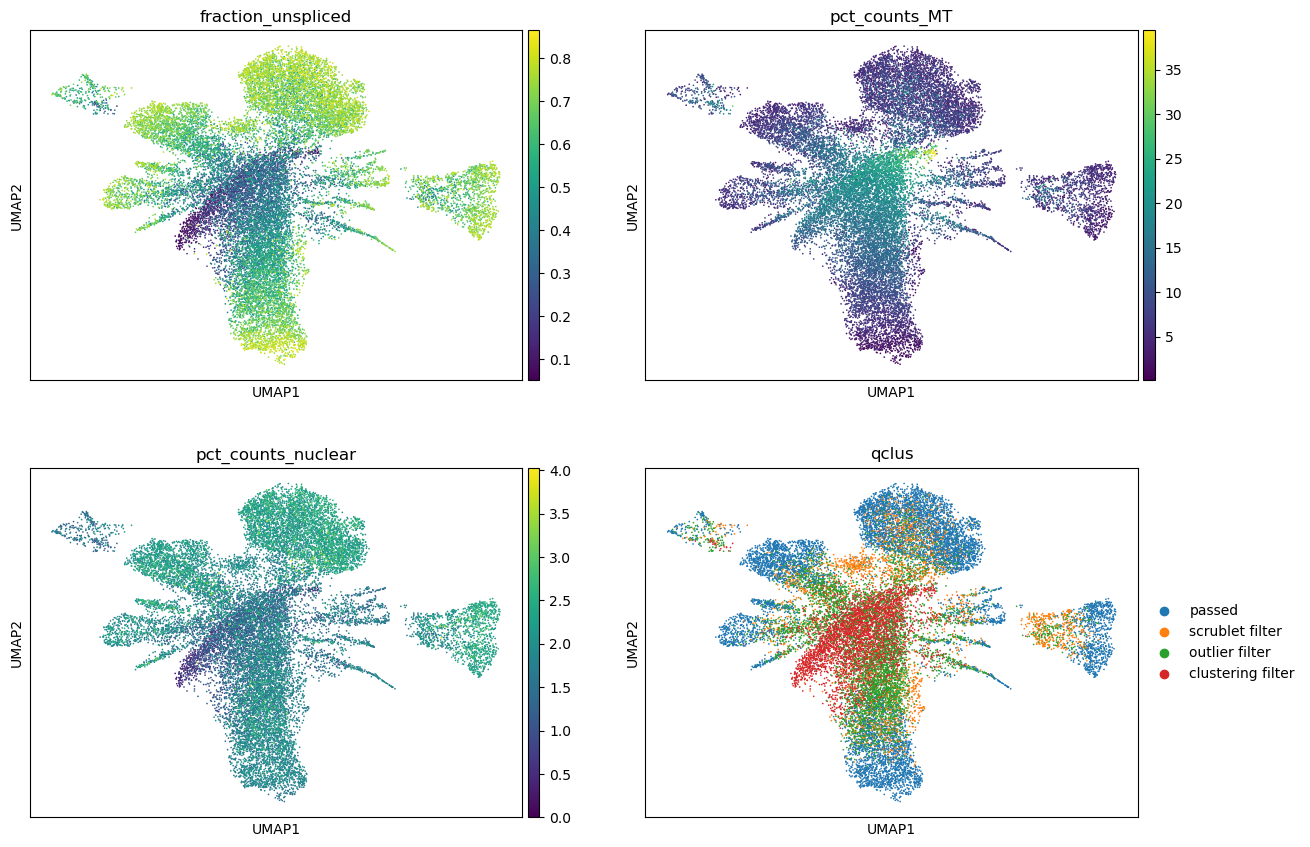

In [26]:
#run standard processing for visualization purposes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#save raw dataset and filter genes
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_MT'], n_jobs = 4)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color=["fraction_unspliced", "pct_counts_MT", "pct_counts_nuclear", "qclus"], ncols=2)

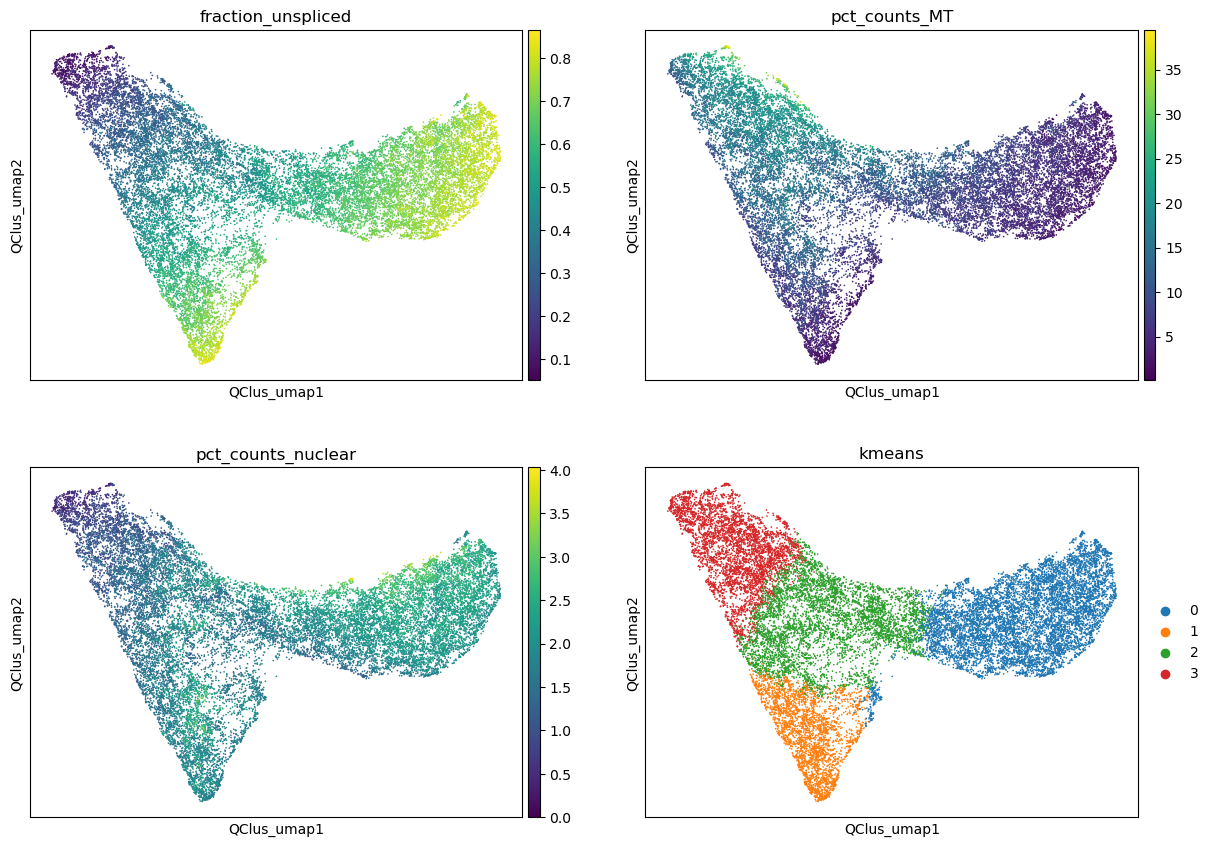

In [27]:
%matplotlib inline
sc.pl.embedding(adata, basis="QClus_umap", color=["fraction_unspliced", "pct_counts_MT", "pct_counts_nuclear", "kmeans"], ncols=2)

In [28]:
adata = adata[adata.obs.qclus=="passed"]
adata

View of AnnData object with n_obs × n_vars = 8245 × 2978
    obs: 'fraction_unspliced', 'n_genes_by_counts', 'total_counts', 'total_counts_nuclear', 'pct_counts_nuclear', 'score_nuclear', 'total_counts_MT', 'pct_counts_MT', 'score_MT', 'total_counts_MT_nucl', 'pct_counts_MT_nucl', 'score_MT_nucl', 'total_counts_CM_cyto', 'pct_counts_CM_cyto', 'score_CM_cyto', 'total_counts_CM_nucl', 'pct_counts_CM_nucl', 'score_CM_nucl', 'total_counts_VEC', 'pct_counts_VEC', 'score_VEC', 'total_counts_PER', 'pct_counts_PER', 'score_PER', 'total_counts_SMC', 'pct_counts_SMC', 'score_SMC', 'total_counts_AD', 'pct_counts_AD', 'score_AD', 'total_counts_SC', 'pct_counts_SC', 'score_SC', 'total_counts_N', 'pct_counts_N', 'score_N', 'total_counts_EEC', 'pct_counts_EEC', 'score_EEC', 'total_counts_FB', 'pct_counts_FB', 'score_FB', 'total_counts_L', 'pct_counts_L', 'score_L', 'total_counts_MESO', 'pct_counts_MESO', 'score_MESO', 'total_counts_MP', 'pct_counts_MP', 'score_MP', 'pct_counts_nonCM', 'kmeans', 'qclu

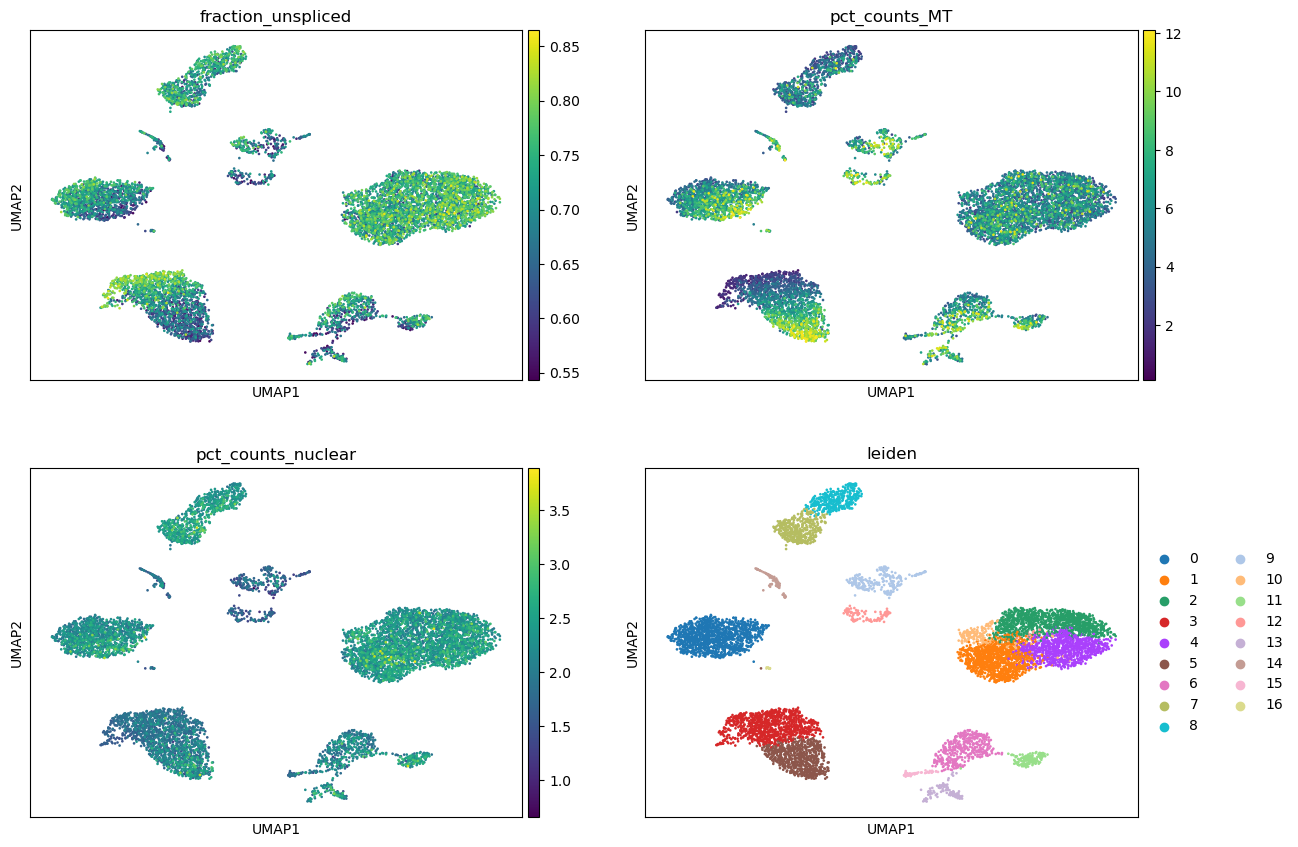

In [29]:
sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color=["fraction_unspliced", "pct_counts_MT", "pct_counts_nuclear", "leiden"], ncols=2)